# Ch09_1.다층신경망(MLP)

## 1.기본 package 설정

In [1]:
## 1.기본
import numpy as np  # numpy 패키지 가져오기
import matplotlib.pyplot as plt # 시각화 패키지 가져오기

## 2.데이터 가져오기
import pandas as pd # csv -> dataframe으로 전환
from sklearn import datasets # python 저장 데이터 가져오기

## 3.데이터 전처리
from sklearn.preprocessing import StandardScaler # 연속변수의 표준화
from sklearn.preprocessing import LabelEncoder # 범주형 변수 수치화

# 4. 훈련/검증용 데이터 분리
from sklearn.model_selection import train_test_split 

## 5.분류모델구축 (3장.p.83~130)
# from sklearn.tree import DecisionTreeClassifier # 결정 트리
# from sklearn.naive_bayes import GaussianNB # 나이브 베이즈
# from sklearn.neighbors import KNeighborsClassifier # K-최근접 이웃
# from sklearn.ensemble import RandomForestClassifier # 랜덤 포레스트
# from sklearn.ensemble import BaggingClassifier # 앙상블
# from sklearn.linear_model import Perceptron # 퍼셉트론
# from sklearn.linear_model import LogisticRegression # 로지스틱 회귀 모델
# from sklearn.svm import SVC # 서포트 벡터 머신(SVM)
from sklearn.neural_network import MLPClassifier # 다층인공신경망

## 6.모델검정
from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score # 정확도, 민감도 등
from sklearn.metrics import roc_curve, auc # ROC 곡선 그리기

## 7.최적화
from sklearn.model_selection import cross_validate # 교차타당도
from sklearn.pipeline import make_pipeline # 파이프라인 구축
from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV # 하이퍼파라미터 튜닝

## 2.데이터 가져오기

### 2.1 데이터프레임으로 저장
- 원본데이터(csv)를 dataframe 형태로 가져오기(pandas)

In [2]:
accidents_df = pd.read_csv('accidentsnn.csv')
accidents_df.head()

,ALCHL_I,PROFIL_I_R,SUR_COND,VEH_INVL,MAX_SEV_IR
0,2,0,1,1,0
1,2,1,1,1,2
2,1,0,1,1,0
3,2,0,2,2,1
4,2,1,1,2,1


- 자료구조 살펴보기

In [3]:
accidents_df.shape

(999, 5)

In [4]:
# 자료구조 살펴보기
accidents_df.keys()

Index(['ALCHL_I', 'PROFIL_I_R', 'SUR_COND', 'VEH_INVL', 'MAX_SEV_IR'], dtype='object')

### 2.2 data와 target으로 분리
- 필요한 데이터만 추출
- data: X, target: y 로 분리

In [5]:
X = accidents_df.drop (['MAX_SEV_IR'], axis=1)
X.head()

,ALCHL_I,PROFIL_I_R,SUR_COND,VEH_INVL
0,2,0,1,1
1,2,1,1,1
2,1,0,1,1
3,2,0,2,2
4,2,1,1,2


In [6]:
y = accidents_df['MAX_SEV_IR']
np.bincount(y)

array([551, 299, 149], dtype=int64)

## 3.데이터 전처리

### 3.1 data(X) 레이블 인코딩
- 문자형 자료를 숫자(범주형)로 인코딩 -> 범주형 변수를 가변수로 처리 : One Hot Encording
- 숫자형 자료를 표준화
- 단, 결정나무, 랜덤 포레스트, 나이브 베이즈 분류 : 원본데이터 그대로 유지

- 가변수 처리시 문자로 처리를 해야 변수명 구분이 쉬움

In [7]:
X['ALCHL_I'] = X['ALCHL_I'].replace ([1,2], ['Yes','No'])

In [8]:
X['PROFIL_I_R'] = X['PROFIL_I_R'].replace ([0,1], ['etc','level1'])

In [9]:
X['SUR_COND'] = X['SUR_COND'].replace ([1,2,3,9], ['dry','wet','snow','non'])

In [10]:
X.head()

,ALCHL_I,PROFIL_I_R,SUR_COND,VEH_INVL
0,No,etc,dry,1
1,No,level1,dry,1
2,Yes,etc,dry,1
3,No,etc,wet,2
4,No,level1,dry,2


In [11]:
X.keys()

Index(['ALCHL_I', 'PROFIL_I_R', 'SUR_COND', 'VEH_INVL'], dtype='object')

In [12]:
X = pd.get_dummies(X[['ALCHL_I', 'PROFIL_I_R', 'VEH_INVL', 'SUR_COND']],
                   columns=['ALCHL_I', 'PROFIL_I_R', 'SUR_COND'], 
                   drop_first=True)

In [13]:
X.head()

,VEH_INVL,ALCHL_I_Yes,PROFIL_I_R_level1,SUR_COND_dry,SUR_COND_non,SUR_COND_snow,SUR_COND_wet
0,1,0,0,1,0,0,0
1,1,0,1,1,0,0,0
2,1,1,0,1,0,0,0
3,2,0,0,0,0,0,1
4,2,0,1,1,0,0,0


### 3.2 Class(target) 레이블 인코딩
- class를 각각 나누어서 3개로 분류

In [14]:
y = pd.get_dummies(y)

In [15]:
y

,0,1,2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,1,0
4,0,1,0
...,...,...,...
994,1,0,0
995,1,0,0
996,0,1,0
997,0,0,1


## 4.훈련/검증용 데이터 분할

### 4.1 훈련/검증용 데이터 분할
- test_size: 검증데이터 30%
- random_state : random seed 번호 = 1
- stratify : y(클래스)의 비율에 따라 분할

In [16]:
# \ 이후에 space 없어야 함
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, 
                         test_size=0.3, 
                         random_state=1, 
                         stratify=y)

### 4.2 data(X) 수치형 데이터 표준화 
- 표준화는 훈련용 데이터를 표준화한 포멧을 test 데이터에도 적용함
- 훈련용 데이터 표준화할 때 사용한 평균과 표준편차를 test데이터에 적용해서 변환

In [17]:
stdsc = StandardScaler()
X_train.iloc[:,[0]]= stdsc.fit_transform(X_train.iloc[:,[0]])
X_test.iloc[:,[0]]= stdsc.transform(X_test.iloc[:,[0]])

C:\Users\leecho\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\leecho\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [18]:
X_train

,VEH_INVL,ALCHL_I_Yes,PROFIL_I_R_level1,SUR_COND_dry,SUR_COND_non,SUR_COND_snow,SUR_COND_wet
652,-0.507956,0,0,1,0,0,0
887,-0.507956,0,0,0,0,0,0
488,-0.507956,0,0,0,0,0,1
752,1.215643,0,1,0,0,0,1
288,-0.507956,0,1,1,0,0,0
...,...,...,...,...,...,...,...
683,1.215643,0,0,0,0,0,1
466,-0.507956,1,0,1,0,0,0
805,1.215643,1,1,1,0,0,0
391,-0.507956,0,0,1,0,0,0


In [19]:
X_test

,VEH_INVL,ALCHL_I_Yes,PROFIL_I_R_level1,SUR_COND_dry,SUR_COND_non,SUR_COND_snow,SUR_COND_wet
633,-0.507956,0,0,1,0,0,0
742,2.939243,0,0,0,0,0,1
337,-0.507956,0,0,1,0,0,0
605,-0.507956,0,0,1,0,0,0
27,-0.507956,0,0,1,0,0,0
...,...,...,...,...,...,...,...
526,-0.507956,0,0,1,0,0,0
629,-0.507956,0,0,1,0,0,0
289,-0.507956,0,0,1,0,0,0
203,-0.507956,0,0,1,0,0,0


## 5.모델구축

- alpha : L2 penalty

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [20]:
mlp = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5,
                    hidden_layer_sizes=(10, 10), 
                    random_state=1)

mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

## 6. 모델검정

### 6.1 검증용 데이터로 예측
- Class로 결과 산출: mlp.predict(X_test)
- 확률값으로 결과 산출: mlp.predict_proba(X_test)
- 3개 클래스로 구분한 후에 한개로 결합

In [21]:
y_pred = pd.DataFrame(mlp.predict(X_test))
y_pred

,0,1,2
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
295,1,0,0
296,1,0,0
297,1,0,0
298,1,0,0


- predict calss를 한개로 결합

In [22]:
y_pred = y_pred.idxmax(axis=1)
y_pred

0      0
1      1
2      0
3      0
4      0
      ..
295    0
296    0
297    0
298    0
299    0
Length: 300, dtype: int64

- test calss를 한개로 결합

In [23]:
y_test = y_test.idxmax(axis=1)
y_test

633    0
742    1
337    2
605    0
27     0
      ..
526    0
629    0
289    0
203    0
506    0
Length: 300, dtype: int64

### 6.2 정오분류표로 검정

- class label이 3개 이므로 추가

In [24]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]','True[2]'],
                      columns=['Predict[0]', 'Predict[1]','Predict[2]'])
confmat

,Predict[0],Predict[1],Predict[2]
True[0],165,0,0
True[1],0,87,3
True[2],16,22,7


In [25]:
print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       165
           1       0.80      0.97      0.87        90
           2       0.70      0.16      0.25        45

    accuracy                           0.86       300
   macro avg       0.80      0.71      0.69       300
weighted avg       0.85      0.86      0.83       300



### 6.3 정확도, 민감도 확인
- 클래스가 2개일 경우에만 실행

In [26]:
# print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
# print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
# print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
# print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

정확도: 0.863


### 6.4 ROC 곡선 그리기
- 클래스가 2개일 경우에만 실행

## 7.최적화
- 교재 6장 (pp.218~250)

### 7.1 파이프라인 모델 만들기
- 파이프라인을 이용하여 최적 모델 만들기
- 기본모형은 아무 옵션이 없는 모델로 부터 시작
- 파라미터 옵션 확인: pipe_tree.get_params().keys()

In [27]:
pipe_mlp = make_pipeline(MLPClassifier(solver='lbfgs',
                                       random_state=1))

In [28]:
pipe_mlp.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'mlpclassifier', 'mlpclassifier__activation', 'mlpclassifier__alpha', 'mlpclassifier__batch_size', 'mlpclassifier__beta_1', 'mlpclassifier__beta_2', 'mlpclassifier__early_stopping', 'mlpclassifier__epsilon', 'mlpclassifier__hidden_layer_sizes', 'mlpclassifier__learning_rate', 'mlpclassifier__learning_rate_init', 'mlpclassifier__max_iter', 'mlpclassifier__momentum', 'mlpclassifier__n_iter_no_change', 'mlpclassifier__nesterovs_momentum', 'mlpclassifier__power_t', 'mlpclassifier__random_state', 'mlpclassifier__shuffle', 'mlpclassifier__solver', 'mlpclassifier__tol', 'mlpclassifier__validation_fraction', 'mlpclassifier__verbose', 'mlpclassifier__warm_start'])

### 7.2 학습 곡선으로 편향과 분산 문제 분석하기
- 훈렴 샘플링 수를 이용하여 편향과 분산 검정
- 편향: 정확도가 높은지 검정
- 분산: 훈련/검정 데이터의 정확도의 차이가 적은지

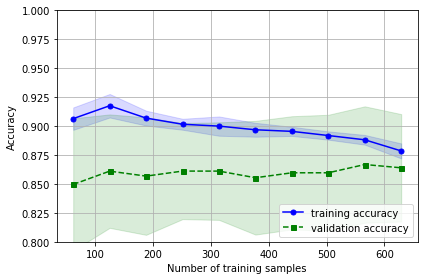

In [29]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_mlp, # 수정
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])  # 수정
plt.tight_layout()
plt.show()

### 7.3 검증 곡선으로 과대적합과 과소적합 조사하기
- 과대적합 : 파라미터가 많음 -> 파라미터 축소
- 과소적합 : 파라미터가 적음 -> 파라미터 추가

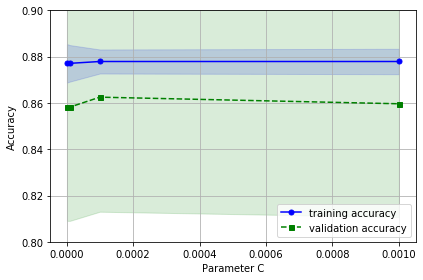

In [30]:
param_range = [1e-06, 1e-05, 0.0001, 0.001]  # 수정

train_scores, test_scores = validation_curve(
                estimator=pipe_mlp, # 수정
                X=X_train, 
                y=y_train, 
                param_name='mlpclassifier__alpha', ## 수정
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of C') # 수정
plt.legend(loc='lower right')
plt.xlabel('Parameter C') # 수정
plt.ylabel('Accuracy')
plt.ylim([0.8, 0.9])  # 수정
plt.tight_layout()
plt.show()

### 7.4 하이퍼파라미터 튜닝
- 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝
- 기계학습 모델의 성능을 결정하는 하이퍼 파라미터 튜닝

In [31]:
param_range1 = [(5, 5), (5, 10), (10, 5), (10, 10)] # 수정
param_range2 = [1e-06, 1e-05, 0.0001, 0.001]   # 수정
param_grid = [{'mlpclassifier__hidden_layer_sizes': param_range1, # 수정
               'mlpclassifier__alpha': param_range2}] # 수정

gs = GridSearchCV(estimator=pipe_mlp, # 수정
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.8655221745350501
{'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': (5, 10)}


C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 8.최적화 모델 검정
- 최적모델을 이용해 검정 데이터(full data) 최종 확인
- best_tree 로 모델명 변경

In [32]:
best_mlp = gs.best_estimator_
best_mlp.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('mlpclassifier',
                 MLPClassifier(activation='relu', alpha=0.001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(5, 10),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=200,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=1, shuffle=True, solver='lbfgs',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

- 검증용 데이터로 예측

In [33]:
y_pred = pd.DataFrame(best_mlp.predict(X_test))
y_pred

,0,1,2
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
295,1,0,0
296,1,0,0
297,1,0,0
298,1,0,0


In [34]:
y_pred = y_pred.idxmax(axis=1)
y_pred

0      0
1      1
2      0
3      0
4      0
      ..
295    0
296    0
297    0
298    0
299    0
Length: 300, dtype: int64

- 정오분류표로 검정

In [35]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]','True[2]'],
                      columns=['Predict[0]', 'Predict[1]','Predict[2]'])
confmat

,Predict[0],Predict[1],Predict[2]
True[0],165,0,0
True[1],0,87,3
True[2],15,22,8


In [36]:
print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       165
           1       0.80      0.97      0.87        90
           2       0.73      0.18      0.29        45

    accuracy                           0.87       300
   macro avg       0.81      0.71      0.71       300
weighted avg       0.85      0.87      0.83       300



- 정확도, 민감도 확인

In [37]:
# print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
# print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
# print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
# print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

정확도: 0.867
